In [126]:
import numpy as np
import matplotlib.pyplot as plt

import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, ConstraintList, Objective, SolverFactory, value, RangeSet, Constraint, Param
from pyomo.dae import *

import jax
import jax.numpy as jnp

from scipy.interpolate import interp1d

import sys
import os

collocation2_path = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data

### `ode_func` has to be replaced by a `neural network`

In [127]:
def ode_func(y, t, c = 1):
    return -c*y

Ipopt 3.14.16: max_iter=500


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:     4459
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4186

Total number of variables............................:       91
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49

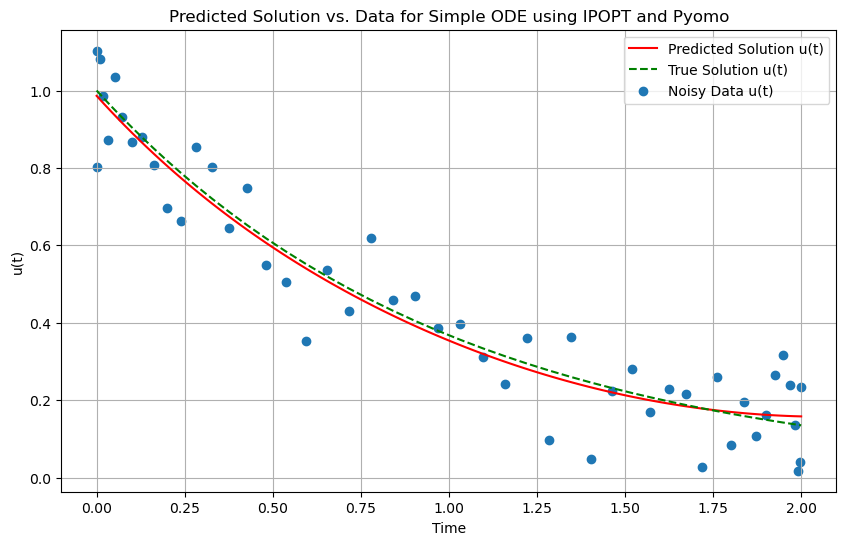

In [128]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 50
noise_level = 0.1
ode_type = "decay"
params = {"c": 1}
start_time=0
end_time=2
spacing_type="chebyshev"
initial_state = jnp.array([1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#---------------------------COLLOCATION MATRIX--------------------------#
weights = compute_weights(t)
D = lagrange_derivative(t, weights)
D = np.array(D)

#---------------------------MODEL CREATION--------------------------#
model = ConcreteModel()
model.t_idx = RangeSet(0, len(y_noisy)-1)

#---------------------------VARIABLE DEFINITIONS--------------------------#
model.u = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1)
# model.C = pyo.Var(domain=pyo.Reals, initialize=1.0) # adding c as a variable

input_size = 2  # t, u
hidden_size = 10 
output_size = 1  # u

#--------------------WEIGHTS AND BIASES----------------------#
def initialize_weights(shape):
    return np.random.randn(*shape) * 0.1

def initialize_biases(size):
    return np.random.randn(size) * 0.1

model.W1 = pyo.Var(range(hidden_size), range(input_size), initialize=lambda m, i, j: initialize_weights((hidden_size, input_size))[i, j])
model.b1 = pyo.Var(range(hidden_size), initialize=lambda m, i: initialize_biases(hidden_size)[i])
model.W2 = pyo.Var(range(output_size), range(hidden_size), initialize=lambda m, i, j: initialize_weights((output_size, hidden_size))[i, j])
model.b2 = pyo.Var(range(output_size), initialize=lambda m, i: initialize_biases(output_size)[i])

#---------------------------INITIAL CONDITIONS---------------------------#
# model.initial_conditions = ConstraintList() 
# model.initial_conditions.add(model.u[0] == 1.0)

#---------------------------NEURAL NETWORK DEFINITIONS---------------------------#
def nn_output(t, u, m):
    # hidden layer (tanh activation)
    hidden_layer = [sum(m.W1[i, j] * (t if j == 0 else u) for j in range(input_size)) + m.b1[i] for i in range(hidden_size)]
    hidden_layer_tanh = [pyo.tanh(z) for z in hidden_layer]
    
    # output layer
    output = sum(m.W2[0, i] * hidden_layer_tanh[i] for i in range(hidden_size)) + m.b2[0]
    return output

#---------------------------ODE CONSTRAINTS USING COLLOCATION MATRIX--------------------------#
penalty_terms = []
penalty_lambda = 500
# ODE constraints using collocation matrix
model.ode = ConstraintList()
for i in range(1, N):
    du_dt = sum(D[i, j] * model.u[j] for j in range(N))
        # collocation constraints using the neural network function
    collocation_constraint = nn_output(t[i], model.u[i], model) - du_dt
    model.ode.add(collocation_constraint == 0)
    
    penalty_terms.append((collocation_constraint)**2)

#---------------------------OBJECTIVE FUNCTION DEFINITION--------------------------#
def _objective(m):
    data_fit = sum((m.u[i] - y_noisy[i])**2 for i in m.t_idx)
    penalty = penalty_lambda * sum(penalty_terms)
    return penalty + data_fit

model.obj = Objective(rule=_objective, sense=pyo.minimize)
    
#---------------------------SOLVING THE MODEL--------------------------#
solver = pyo.SolverFactory('ipopt')

"""solver.options['tol'] = 1e-6
solver.options['bound_push'] = 1e-8
solver.options['constr_viol_tol'] = 1e-8"""

solver.options['max_iter'] = 500
solver.solve(model, tee=True)

#---------------------------EXTRACTING RESULTS--------------------------#
u_solution = np.array([value(model.u[i]) for i in model.t_idx])
# print(f"{value(model.C):.4f}")

#---------------------------INTERPOLATION--------------------------#
interp_fn = interp1d(t, u_solution, kind='cubic', fill_value='extrapolate')
x_new = np.linspace(t[0], t[-1], 100)
y_new = interp_fn(x_new)

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 6))
plt.plot(x_new, y_new, 'r', label='Predicted Solution u(t)')
plt.plot(t, y, 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy, label='Noisy Data u(t)')
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend()
plt.title('Predicted Solution vs. Data for Simple ODE using IPOPT and Pyomo')
plt.grid(True)
plt.show()

----

In [186]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type = "harmonic_oscillator"
params = {"omega_squared": 1}
start_time=0
end_time=10
spacing_type="chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#---------------------------COLLOCATION MATRIX--------------------------#
weights = compute_weights(t)
D = lagrange_derivative(t, weights)
D = np.array(D)

#---------------------------MODEL CREATION--------------------------#
model = ConcreteModel()
model.t_idx = RangeSet(0, len(y_noisy)-1)
model.dim_idx = RangeSet(0, 1)

#---------------------------VARIABLE DEFINITIONS--------------------------#
model.u = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1)
model.v = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1)

input_size = 3  # t, u, v
hidden_size = 10  
output_size = 2  # du/dt and dv/dt

#--------------------WEIGHTS AND BIASES----------------------#
def initialize_weights(shape):
    return np.random.randn(*shape) * 0.1

def initialize_biases(size):
    return np.random.randn(size) * 0.1

model.W1 = pyo.Var(range(hidden_size), range(input_size), initialize=lambda m, i, j: initialize_weights((hidden_size, input_size))[i, j])
model.b1 = pyo.Var(range(hidden_size), initialize=lambda m, i: initialize_biases(hidden_size)[i])
model.W2 = pyo.Var(range(output_size), range(hidden_size), initialize=lambda m, i, j: initialize_weights((output_size, hidden_size))[i, j])
model.b2 = pyo.Var(range(output_size), initialize=lambda m, i: initialize_biases(output_size)[i])

#---------------------------INITIAL CONDITIONS---------------------------#
# model.initial_conditions = ConstraintList() 
# model.initial_conditions.add(model.u[0] == 1.0)

#---------------------------NEURAL NETWORK DEFINITIONS---------------------------#
def nn_output(t, u, v, m):
    # hidden layer (tanh activation)
    # the order is: t, u, v
    hidden_layer = [sum(m.W1[i, j] * (t if j == 0 else u if j == 1 else v) for j in range(input_size)) + m.b1[i] for i in range(hidden_size)]
    hidden_layer_tanh = [pyo.tanh(z) for z in hidden_layer]
    
    # output layer
    output = [sum(m.W2[k, i] * hidden_layer_tanh[i] for i in range(hidden_size)) + m.b2[k] for k in range(output_size)]
    return output

#---------------------------ODE CONSTRAINTS USING COLLOCATION MATRIX--------------------------#
penalty_terms = []
penalty_lambda = 5000
# ODE constraints using collocation matrix
model.ode = ConstraintList()
for i in range(1, N):
    du_dt = sum(D[i, j] * model.u[j] for j in range(N))
    dv_dt = sum(D[i, j] * model.v[j] for j in range(N))
    
    nn_u, nn_v = nn_output(t[i], model.u[i], model.v[i], model)
    
    collocation_constraint_u = nn_u - du_dt
    collocation_constraint_v = nn_v - dv_dt
    
    model.ode.add(collocation_constraint_u == 0)
    model.ode.add(collocation_constraint_v == 0)
    
    penalty_terms.append((collocation_constraint_u)**2 + (collocation_constraint_v)**2)

#---------------------------OBJECTIVE FUNCTION DEFINITION--------------------------#
def _objective(m):
    data_fit = sum((m.u[i] - y_noisy[i, 0])**2 + (m.v[i] - y_noisy[i, 1])**2 for i in m.t_idx)
    penalty = penalty_lambda * sum(penalty_terms)
    return penalty + data_fit

model.obj = Objective(rule=_objective, sense=pyo.minimize)
    
#---------------------------SOLVING THE MODEL--------------------------#
solver = pyo.SolverFactory('ipopt')

"""solver.options['tol'] = 1e-6
solver.options['bound_push'] = 1e-8
solver.options['constr_viol_tol'] = 1e-8"""

solver.options['max_iter'] = 750
solver.solve(model, tee=True)

Ipopt 3.14.16: max_iter=750


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   100296
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   106809

Total number of variables............................:      462
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      398

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 398, 'Number of variables': 462, 'Sense': 'unknown'}], 'Solver': [{'Status': 'warning', 'Message': 'Ipopt 3.14.16\\x3a Maximum Number of Iterations Exceeded.', 'Termination condition': 'maxIterations', 'Id': 400, 'Error rc': 0, 'Time': 82.16502094268799}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

0.022214694392182596


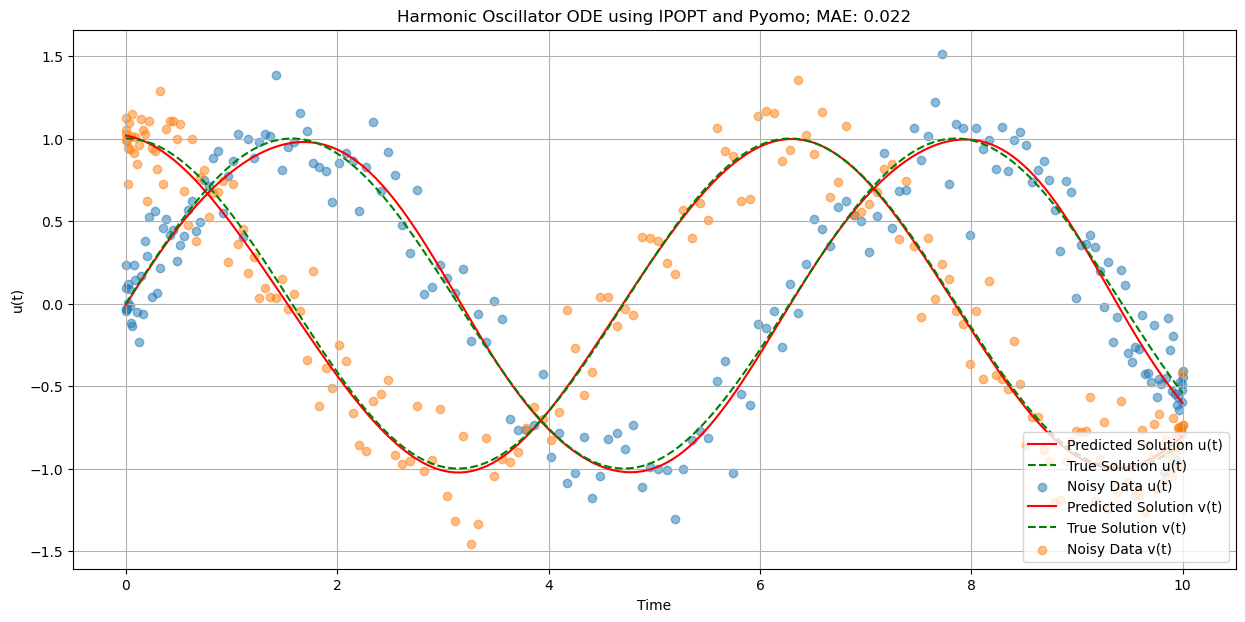

In [187]:
#---------------------------EXTRACTING RESULTS--------------------------#
u_solution = np.array([value(model.u[i]) for i in model.t_idx])
v_solution = np.array([value(model.v[i]) for i in model.t_idx])

#---------------------------INTERPOLATION--------------------------#
N_interpolation = 200
interp_fn = interp1d(t, u_solution, kind='cubic', fill_value='extrapolate')
x_new = np.linspace(t[0], t[-1], N_interpolation)
u_new = interp_fn(x_new)

interp_fn = interp1d(t, v_solution, kind='cubic', fill_value='extrapolate')
x_new = np.linspace(t[0], t[-1], N_interpolation)
v_new = interp_fn(x_new)

#---------------------------MEAN ABSOLUTE ERROR--------------------------#
t_temp, y_temp, _, _ = generate_ode_data(N_interpolation, noise_level, ode_type, params, start_time, end_time, "equally_spaced", initial_state)
combined = np.vstack((u_new, v_new)).T
MAE = np.mean(np.abs(y_temp - combined))
print(MAE)

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(x_new, u_new, 'r', label='Predicted Solution u(t)')
plt.plot(t_temp, y_temp.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

plt.plot(x_new, v_new, 'r', label='Predicted Solution v(t)')
plt.plot(t_temp, y_temp.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.title(f'Harmonic Oscillator ODE using IPOPT and Pyomo; MAE: {MAE:.3f}')
plt.grid(True)
plt.show()

### `Extracting Model Parameters`

In [201]:
W1_learned = np.zeros((hidden_size, input_size))
b1_learned = np.zeros(hidden_size)
W2_learned = np.zeros((output_size, hidden_size))
b2_learned = np.zeros(output_size)

for i in range(hidden_size):
    for j in range(input_size):
        W1_learned[i, j] = pyo.value(model.W1[i, j])
    b1_learned[i] = pyo.value(model.b1[i])

for k in range(output_size):
    for i in range(hidden_size):
        W2_learned[k, i] = pyo.value(model.W2[k, i])
    b2_learned[k] = pyo.value(model.b2[k])

In [200]:
print(f"W1 shape: {W1_learned.shape}")
print(f"b1 shape: {b1_learned.shape}")
print(f"W2 shape: {W2_learned.shape}")
print(f"b2 shape: {b2_learned.shape}")

W1 shape: (10, 3)
b1 shape: (10,)
W2 shape: (2, 10)
b2 shape: (2,)


### Pass in the extracted model into `odeint`

In [ ]:
import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint

In [202]:
def predict(t, u, v, W1, b1, W2, b2):
    inputs = jnp.array([t, u, v])
    hidden_layer = jax.nn.tanh(jnp.dot(W1, inputs) + b1)
    output_layer = jnp.dot(W2, hidden_layer) + b2
    return output_layer  # returns [du/dt, dv/dt]

def system_dynamics(y, t, W1, b1, W2, b2):
    u, v = y
    du_dt, dv_dt = predict(t, u, v, W1, b1, W2, b2)
    return jnp.array([du_dt, dv_dt])

In [203]:
initial_conditions = jnp.array([0.0, 1.0])  # starting values for u and v
t_values = jnp.linspace(0, 20, 200)  # time points from 0 to 20

# Using JAX odeint to solve the ODE
solution = odeint(system_dynamics, initial_conditions, t_values, W1_learned, b1_learned, W2_learned, b2_learned)
u_values, v_values = solution[:, 0], solution[:, 1]

In [204]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.0
ode_type = "harmonic_oscillator"
params = {"omega_squared": 1}
start_time=0
end_time=20
spacing_type="chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_temp, y_temp, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

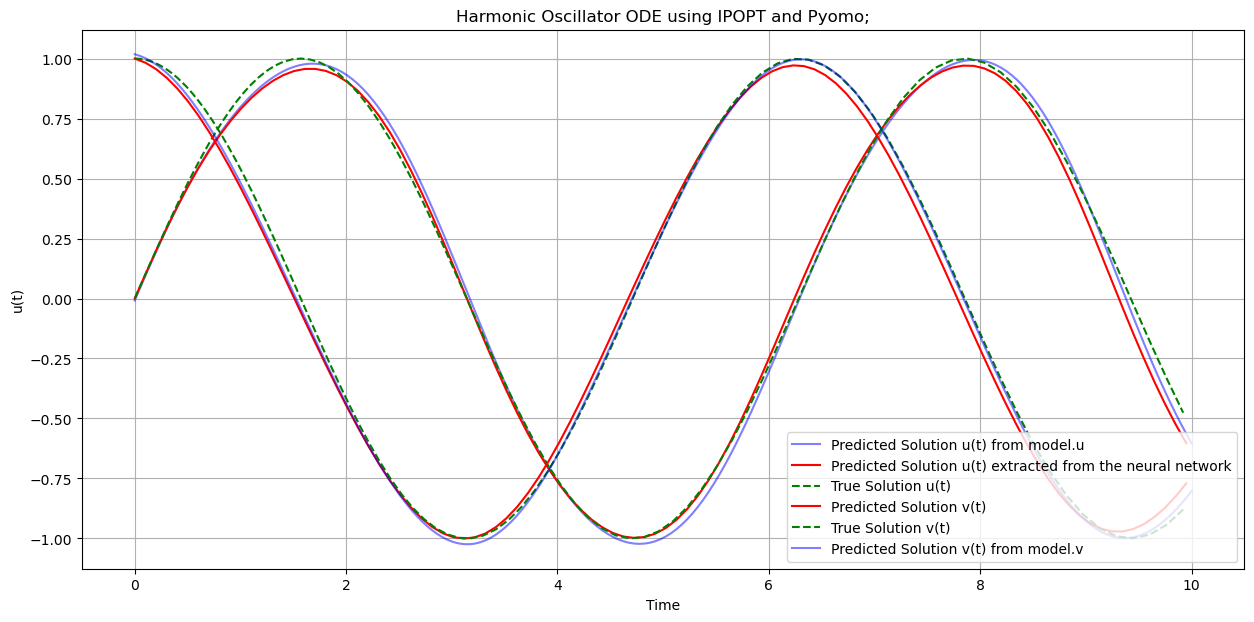

In [231]:
beg = 0
end = 100

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(x_new, u_new, 'b', label='Predicted Solution u(t) from model.u', alpha = 0.5)
plt.plot(t_values[beg:end], u_values[beg:end], 'r', label='Predicted Solution u(t) extracted from the neural network')
plt.plot(t_temp[beg:end], y_temp.T[0][beg:end], 'g--', label='True Solution u(t)')
#plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

plt.plot(t_values[beg:end], v_values[beg:end], 'r', label='Predicted Solution v(t)')
plt.plot(t_temp[beg:end], y_temp.T[1][beg:end], 'g--', label='True Solution v(t)')
plt.plot(x_new, v_new, 'b', label='Predicted Solution v(t) from model.v', alpha = 0.5)
#plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.title(f'Harmonic Oscillator ODE using IPOPT and Pyomo;')
plt.grid(True)
plt.show()

### `Parameter optimization` of:
* penalty_lambda
* no of training epochs
* activation function
* weight initializations
* network architecture

Let's fix the rest of the parameters:
* omega = 1
* noise level = 0.2

We can pre-generate the data for this experiment:

In [10]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.5
ode_type = "harmonic_oscillator"
params = {"omega_squared": 1}
start_time=0
end_time=10
spacing_type="chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#---------------------------COLLOCATION MATRIX--------------------------#
weights = compute_weights(t)
D = lagrange_derivative(t, weights)
D = np.array(D)

`itroducing parameters to optimize`

In [75]:
def optimization_model(penalty_lambda = 100, max_iter = 500, act_func = "tanh", w_init_mehtod = "random"):
    #---------------------------MODEL CREATION--------------------------#
    model = ConcreteModel()
    model.t_idx = RangeSet(0, len(y_noisy)-1)
    model.dim_idx = RangeSet(0, 1)

    #---------------------------VARIABLE DEFINITIONS--------------------------#
    model.u = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1)
    model.v = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1)

    input_size = 3  # t, u, v
    hidden_size = 10  
    output_size = 2  # du/dt and dv/dt

    #--------------------WEIGHTS AND BIASES----------------------#
    # Xavier Initialization
    def xavier_weights(shape):
        return np.random.randn(*shape) * np.sqrt(2 / (shape[0] + shape[1]))

    # He Initialization
    def he_weights(shape):
        return np.random.randn(*shape) * np.sqrt(2 / shape[0])

    # Function to initialize weights and biases
    def initialize_weights(shape, method='random'):
        if method == 'random':
            return np.random.randn(*shape) * 0.1
        elif method == 'xavier':
            return xavier_weights(shape)
        elif method == 'he':
            return he_weights(shape)
        else:
            raise ValueError("Unsupported initialization method. Use 'random', 'xavier', or 'he'.")
        
    def initialize_biases(size, method='random'):
        return np.random.randn(size) * 0.1

    model.W1 = pyo.Var(range(hidden_size), range(input_size), initialize=lambda m, i, j: initialize_weights((hidden_size, input_size), w_init_mehtod)[i, j])
    model.b1 = pyo.Var(range(hidden_size), initialize=lambda m, i: initialize_biases(hidden_size)[i])
    model.W2 = pyo.Var(range(output_size), range(hidden_size), initialize=lambda m, i, j: initialize_weights((output_size, hidden_size), w_init_mehtod)[i, j])
    model.b2 = pyo.Var(range(output_size), initialize=lambda m, i: initialize_biases(output_size)[i])

    #---------------------------INITIAL CONDITIONS---------------------------#
    # model.initial_conditions = ConstraintList() 
    # model.initial_conditions.add(model.u[0] == 1.0)

    #---------------------------NEURAL NETWORK DEFINITIONS---------------------------#
    
    def nn_output(t, u, v, m):
        hidden_layer_expr = [sum(m.W1[i, j] * (t if j == 0 else u if j == 1 else v) for j in range(input_size)) + m.b1[i] for i in range(hidden_size)]
        
        hidden_layer_output = []
        if act_func == "tanh":
            hidden_layer_output = [pyo.tanh(z) for z in hidden_layer_expr]
        elif act_func == "sigmoid":
            hidden_layer_output = [1 / (1 + pyo.exp(-z)) for z in hidden_layer_expr]
        elif act_func == "softplus":
            hidden_layer_output = [pyo.log(1 + pyo.exp(z)) for z in hidden_layer_expr]
        else:
            raise ValueError("Unsupported activation function. Use 'tanh', 'sigmoid', or 'softplus'.")

        # output layer
        output = [sum(m.W2[k, i] * hidden_layer_output[i] for i in range(hidden_size)) + m.b2[k] for k in range(output_size)]
        return output

    #---------------------------ODE CONSTRAINTS USING COLLOCATION MATRIX--------------------------#
    penalty_terms = []
    # ODE constraints using collocation matrix
    model.ode = ConstraintList()
    for i in range(1, N):
        du_dt = sum(D[i, j] * model.u[j] for j in range(N))
        dv_dt = sum(D[i, j] * model.v[j] for j in range(N))
        
        nn_u, nn_v = nn_output(t[i], model.u[i], model.v[i], model)
        
        collocation_constraint_u = nn_u - du_dt
        collocation_constraint_v = nn_v - dv_dt
        
        model.ode.add(collocation_constraint_u == 0)
        model.ode.add(collocation_constraint_v == 0)
        
        penalty_terms.append((collocation_constraint_u)**2 + (collocation_constraint_v)**2)

    #---------------------------OBJECTIVE FUNCTION DEFINITION--------------------------#
    def _objective(m):
        data_fit = sum((m.u[i] - y_noisy[i, 0])**2 + (m.v[i] - y_noisy[i, 1])**2 for i in m.t_idx)
        penalty = penalty_lambda * sum(penalty_terms)
        return penalty + data_fit

    model.obj = Objective(rule=_objective, sense=pyo.minimize)
        
    #---------------------------SOLVING THE MODEL--------------------------#
    solver = pyo.SolverFactory('ipopt')

    """solver.options['tol'] = 1e-6
    solver.options['bound_push'] = 1e-8
    solver.options['constr_viol_tol'] = 1e-8"""

    solver.options['max_iter'] = max_iter
    solver.solve(model)
    
    return model

* `penalty_lambda` - 0, 0.1, 1, 10, 50, 100, 500, 1000, 5000, 1000 <br>
* fix the number of iterations at `500`

In [120]:
penalty_lambda = np.array([0, 10, 100, 1000, 5000, 10000])

In [121]:
results = {}
iter = 0

for penalty in penalty_lambda:
    iter += 1
    #---------------------------------MODEL---------------------------------#
    model = optimization_model(penalty, max_iter=500)
    #---------------------------EXTRACTING RESULTS--------------------------#
    u_solution = np.array([value(model.u[i]) for i in model.t_idx])
    v_solution = np.array([value(model.v[i]) for i in model.t_idx])

    #------------------------------INTERPOLATION----------------------------#
    N = 200
    interp_fn = interp1d(t, u_solution, kind='cubic', fill_value='extrapolate')
    x_new = np.linspace(t[0], t[-1], N)
    u_new = interp_fn(x_new)

    interp_fn = interp1d(t, v_solution, kind='cubic', fill_value='extrapolate')
    x_new = np.linspace(t[0], t[-1], N)
    v_new = interp_fn(x_new)

    #---------------------------MEAN ABSOLUTE ERROR--------------------------#
    if iter == 1:
        _, y_temp, _, _ = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, "equally_spaced", initial_state)
    combined = np.vstack((u_new, v_new)).T
    MAE = np.mean(np.abs(y_temp - combined))
    print(MAE)
    
    # save results
    results[str(penalty)] = {"MAE":MAE, "u_new":u_new, "v_new":v_new, "x_new":x_new}

model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number of Iterations
      Exceeded.
0.2249793476660346
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number of Iterations
      Exceeded.
0.16208886272697917
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number of Iterations
      Exceeded.
0.11249553155619864
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number of Iterations
      Exceeded.
0.07899102275330334
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number of Iterations
      Exceeded.
0.048968701601396575
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number 

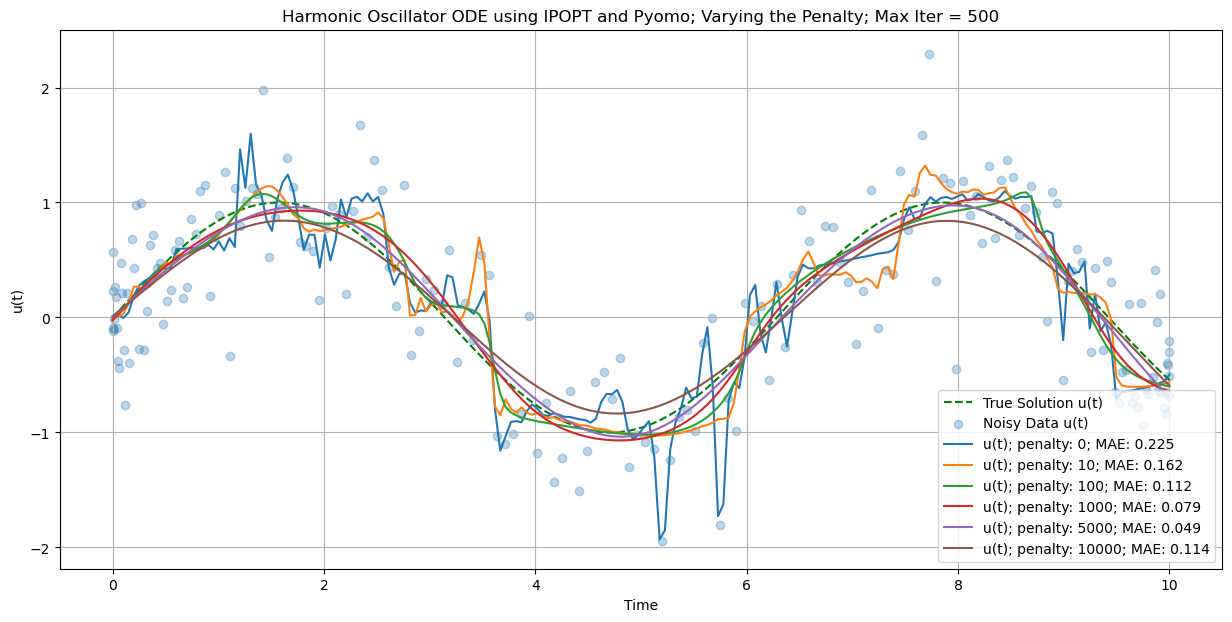

In [125]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t, y.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.3)
i = 0
for penalty in penalty_lambda:
    result = results[str(penalty)]
    u_new = result['u_new']
    x_new = result['x_new']
    plt.plot(x_new, u_new, label=f"u(t); penalty: {penalty}; MAE: {result['MAE']:.3f}")

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.title(f'Harmonic Oscillator ODE using IPOPT and Pyomo; Varying the Penalty; Max Iter = 500')
plt.grid(True)
plt.show()

In [13]:
for penalty in penalty_lambda:
    result = results[str(penalty)]
    MAE = result['MAE']
    print(f"MAE: {MAE:2f}; penalty: {penalty}")

MAE: 0.329061; penalty: 0
MAE: 0.148063; penalty: 10
MAE: 0.113258; penalty: 100
MAE: 0.077159; penalty: 1000
MAE: 0.050627; penalty: 5000
MAE: 0.137294; penalty: 10000


In [17]:
max_iter_li = [100, 250, 750, 1000, 2500, 5000]

In [18]:
results_max_iter = {}
iter = 0

for max_iter in max_iter_li:
    #---------------------------------MODEL---------------------------------#
    model = optimization_model(5000, max_iter)
    #---------------------------EXTRACTING RESULTS--------------------------#
    u_solution = np.array([value(model.u[i]) for i in model.t_idx])
    v_solution = np.array([value(model.v[i]) for i in model.t_idx])

    #------------------------------INTERPOLATION----------------------------#
    N = 200
    interp_fn = interp1d(t, u_solution, kind='cubic', fill_value='extrapolate')
    x_new = np.linspace(t[0], t[-1], N)
    u_new = interp_fn(x_new)

    interp_fn = interp1d(t, v_solution, kind='cubic', fill_value='extrapolate')
    x_new = np.linspace(t[0], t[-1], N)
    v_new = interp_fn(x_new)

    #---------------------------MEAN ABSOLUTE ERROR--------------------------#
    if iter == 1:
        _, y_temp, _, _ = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, "equally_spaced", initial_state)
    combined = np.vstack((u_new, v_new)).T
    MAE = np.mean(np.abs(y_temp - combined))
    print(MAE)
    
    # save results
    results_max_iter[str(max_iter)] = {"MAE":MAE, "u_new":u_new, "v_new":v_new, "x_new":x_new, "max_iter":max_iter}

model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number of Iterations
      Exceeded.
0.5857997156981548
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number of Iterations
      Exceeded.
0.3975890357758859
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number of Iterations
      Exceeded.
0.0617969174370285
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number of Iterations
      Exceeded.
0.08381883489414899
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number of Iterations
      Exceeded.
0.120835762637106
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number of It

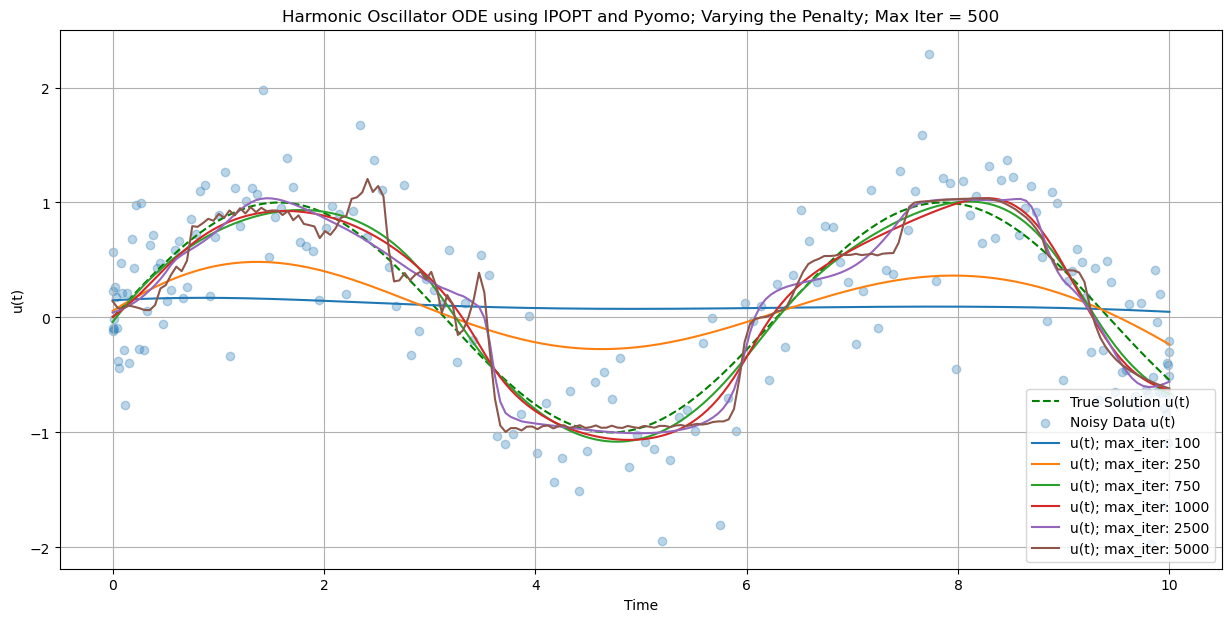

In [19]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t, y.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.3)
i = 0
for max_iter in max_iter_li:
    result = results_max_iter[str(max_iter)]
    u_new = result['u_new']
    x_new = result['x_new']
    plt.plot(x_new, u_new, label=f'u(t); max_iter: {max_iter}')

"""plt.plot(t, y.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)
for penalty in penalty_lambda:
    result = results[str(penalty)]
    v_new = result['v_new']
    x_new = result['x_new']
    plt.plot(x_new, v_new, 'r', label='Predicted Solution v(t)')"""
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.title(f'Harmonic Oscillator ODE using IPOPT and Pyomo; Varying the Penalty; Max Iter = 500')
plt.grid(True)
plt.show()

In [20]:
for max_iter in max_iter_li:
    result = results_max_iter[str(max_iter)]
    MAE = result['MAE']
    print(f"MAE: {MAE:2f}; max_iter: {max_iter}")

MAE: 0.585800; max_iter: 100
MAE: 0.397589; max_iter: 250
MAE: 0.061797; max_iter: 750
MAE: 0.083819; max_iter: 1000
MAE: 0.120836; max_iter: 2500
MAE: 0.152670; max_iter: 5000


`Activation functions:` 'tanh', 'sigmoid', or 'softplus'

In [65]:
act_funcs = ['tanh', 'sigmoid', 'softplus']
results_act_funcs = {}

for act_func in act_funcs:
    #---------------------------------MODEL---------------------------------#
    model = optimization_model(5000, 500, act_func)
    #---------------------------EXTRACTING RESULTS--------------------------#
    u_solution = np.array([value(model.u[i]) for i in model.t_idx])
    v_solution = np.array([value(model.v[i]) for i in model.t_idx])

    #------------------------------INTERPOLATION----------------------------#
    N = 200
    interp_fn = interp1d(t, u_solution, kind='cubic', fill_value='extrapolate')
    x_new = np.linspace(t[0], t[-1], N)
    u_new = interp_fn(x_new)

    interp_fn = interp1d(t, v_solution, kind='cubic', fill_value='extrapolate')
    x_new = np.linspace(t[0], t[-1], N)
    v_new = interp_fn(x_new)

    #---------------------------MEAN ABSOLUTE ERROR--------------------------#
    if iter == 1:
        _, y_temp, _, _ = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, "equally_spaced", initial_state)
    combined = np.vstack((u_new, v_new)).T
    MAE = np.mean(np.abs(y_temp - combined))
    print(MAE)
    
    # save results
    results_act_funcs[act_func] = {"MAE":MAE, "u_new":u_new, "v_new":v_new, "x_new":x_new, "act_func":act_func}

model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number of Iterations
      Exceeded.
0.05186229825257234
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number of Iterations
      Exceeded.
0.04676451726755621
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number of Iterations
      Exceeded.
0.050539072448233364


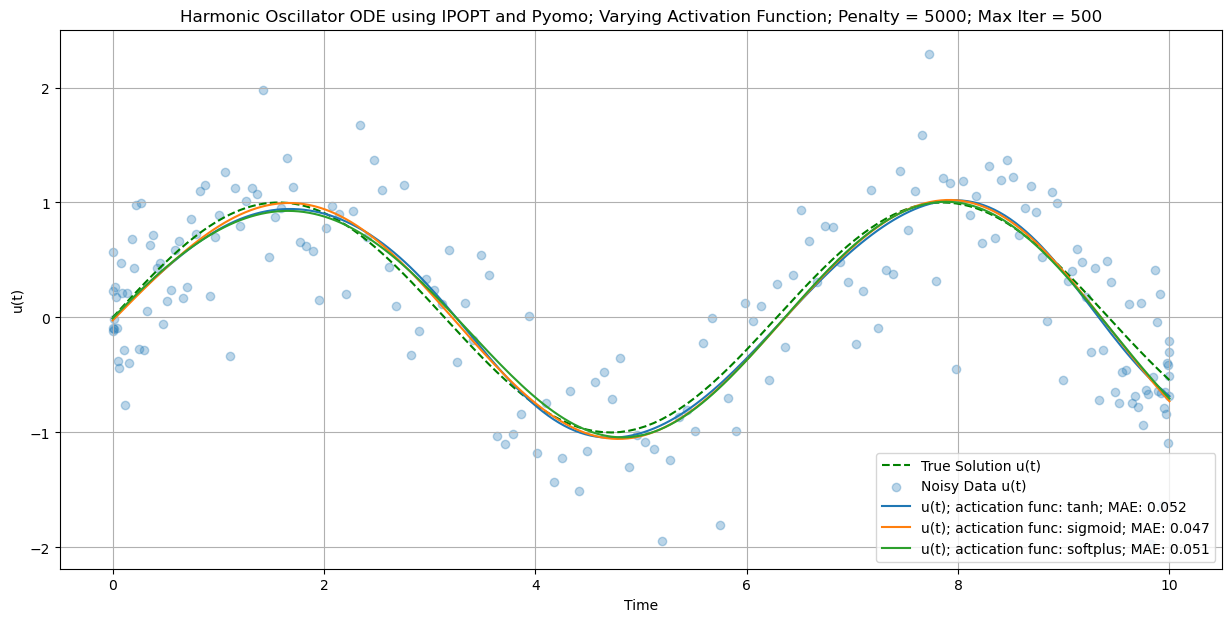

In [70]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t, y.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.3)
i = 0
for act_func in act_funcs:
    result = results_act_funcs[act_func]
    u_new = result['u_new']
    x_new = result['x_new']
    plt.plot(x_new, u_new, label=f"u(t); actication func: {act_func}; MAE: {result['MAE']:.3f}")

"""plt.plot(t, y.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)
for penalty in penalty_lambda:
    result = results[str(penalty)]
    v_new = result['v_new']
    x_new = result['x_new']
    plt.plot(x_new, v_new, 'r', label='Predicted Solution v(t)')"""
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.title(f'Harmonic Oscillator ODE using IPOPT and Pyomo; Varying Activation Function; Penalty = 5000; Max Iter = 500')
plt.grid(True)
plt.show()

`Weight initialization:` can we improve training through effective weight initialization?

In [73]:
model = optimization_model(5000, 500, "sigmoid") # random

#---------------------------EXTRACTING RESULTS--------------------------#
u_solution = np.array([value(model.u[i]) for i in model.t_idx])
v_solution = np.array([value(model.v[i]) for i in model.t_idx])

#------------------------------INTERPOLATION----------------------------#
N = 200
interp_fn = interp1d(t, u_solution, kind='cubic', fill_value='extrapolate')
x_new = np.linspace(t[0], t[-1], N)
u_new = interp_fn(x_new)

interp_fn = interp1d(t, v_solution, kind='cubic', fill_value='extrapolate')
x_new = np.linspace(t[0], t[-1], N)
v_new = interp_fn(x_new)

_, y_temp, _, _ = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, "equally_spaced", initial_state)
combined = np.vstack((u_new, v_new)).T
MAE = np.mean(np.abs(y_temp - combined))
print(MAE)

0.048827531355789607


In [80]:
model = optimization_model(5000, 500, "sigmoid", "xavier")

#---------------------------EXTRACTING RESULTS--------------------------#
u_solution = np.array([value(model.u[i]) for i in model.t_idx])
v_solution = np.array([value(model.v[i]) for i in model.t_idx])

#------------------------------INTERPOLATION----------------------------#
N = 200
interp_fn = interp1d(t, u_solution, kind='cubic', fill_value='extrapolate')
x_new = np.linspace(t[0], t[-1], N)
u_new = interp_fn(x_new)

interp_fn = interp1d(t, v_solution, kind='cubic', fill_value='extrapolate')
x_new = np.linspace(t[0], t[-1], N)
v_new = interp_fn(x_new)

_, y_temp, _, _ = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, "equally_spaced", initial_state)
combined = np.vstack((u_new, v_new)).T
MAE = np.mean(np.abs(y_temp - combined))
print(MAE)

0.05940692958062674


In [81]:
model = optimization_model(5000, 500, "softplus", "he")

#---------------------------EXTRACTING RESULTS--------------------------#
u_solution = np.array([value(model.u[i]) for i in model.t_idx])
v_solution = np.array([value(model.v[i]) for i in model.t_idx])

#------------------------------INTERPOLATION----------------------------#
N = 200
interp_fn = interp1d(t, u_solution, kind='cubic', fill_value='extrapolate')
x_new = np.linspace(t[0], t[-1], N)
u_new = interp_fn(x_new)

interp_fn = interp1d(t, v_solution, kind='cubic', fill_value='extrapolate')
x_new = np.linspace(t[0], t[-1], N)
v_new = interp_fn(x_new)

_, y_temp, _, _ = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, "equally_spaced", initial_state)
combined = np.vstack((u_new, v_new)).T
MAE = np.mean(np.abs(y_temp - combined))
print(MAE)

model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number of Iterations
      Exceeded.
0.05003065664902485


----

In [103]:
def optimization_model_testing(penalty_lambda = 1000, max_iter = 500, act_func = "tanh", w_init_mehtod = "random", y_init = None):
    #---------------------------MODEL CREATION--------------------------#
    model = ConcreteModel()
    model.t_idx = RangeSet(0, len(y_noisy)-1)
    model.dim_idx = RangeSet(0, 1)

    #---------------------------VARIABLE DEFINITIONS--------------------------#
    if y_init == None:
        model.u = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1)
        model.v = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1)
    else:
        model.u = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=np.array(y_init[0]))
        model.v = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=np.array(y_init[1]))

    input_size = 3  # t, u, v
    hidden_size = 10  
    output_size = 2  # du/dt and dv/dt

    #--------------------WEIGHTS AND BIASES----------------------#
    # Xavier Initialization
    def xavier_weights(shape):
        return np.random.randn(*shape) * np.sqrt(2 / (shape[0] + shape[1]))

    # He Initialization
    def he_weights(shape):
        return np.random.randn(*shape) * np.sqrt(2 / shape[0])

    # Function to initialize weights and biases
    def initialize_weights(shape, method='random'):
        if method == 'random':
            return np.random.randn(*shape) * 0.1
        elif method == 'xavier':
            return xavier_weights(shape)
        elif method == 'he':
            return he_weights(shape)
        else:
            raise ValueError("Unsupported initialization method. Use 'random', 'xavier', or 'he'.")
        
    def initialize_biases(size, method='random'):
        return np.random.randn(size) * 0.1

    model.W1 = pyo.Var(range(hidden_size), range(input_size), initialize=lambda m, i, j: initialize_weights((hidden_size, input_size), w_init_mehtod)[i, j])
    model.b1 = pyo.Var(range(hidden_size), initialize=lambda m, i: initialize_biases(hidden_size)[i])
    model.W2 = pyo.Var(range(output_size), range(hidden_size), initialize=lambda m, i, j: initialize_weights((output_size, hidden_size), w_init_mehtod)[i, j])
    model.b2 = pyo.Var(range(output_size), initialize=lambda m, i: initialize_biases(output_size)[i])

    #---------------------------INITIAL CONDITIONS---------------------------#
    # model.initial_conditions = ConstraintList() 
    # model.initial_conditions.add(model.u[0] == 1.0)

    #---------------------------NEURAL NETWORK DEFINITIONS---------------------------#
    
    def nn_output(t, u, v, m):
        hidden_layer_expr = [sum(m.W1[i, j] * (t if j == 0 else u if j == 1 else v) for j in range(input_size)) + m.b1[i] for i in range(hidden_size)]
        
        hidden_layer_output = []
        if act_func == "tanh":
            hidden_layer_output = [pyo.tanh(z) for z in hidden_layer_expr]
        elif act_func == "sigmoid":
            hidden_layer_output = [1 / (1 + pyo.exp(-z)) for z in hidden_layer_expr]
        elif act_func == "softplus":
            hidden_layer_output = [pyo.log(1 + pyo.exp(z)) for z in hidden_layer_expr]
        else:
            raise ValueError("Unsupported activation function. Use 'tanh', 'sigmoid', or 'softplus'.")

        # output layer
        output = [sum(m.W2[k, i] * hidden_layer_output[i] for i in range(hidden_size)) + m.b2[k] for k in range(output_size)]
        return output

    #---------------------------ODE CONSTRAINTS USING COLLOCATION MATRIX--------------------------#
    penalty_terms = []
    # ODE constraints using collocation matrix
    model.ode = ConstraintList()
    for i in range(1, N):
        du_dt = sum(D[i, j] * model.u[j] for j in range(N))
        dv_dt = sum(D[i, j] * model.v[j] for j in range(N))
        
        nn_u, nn_v = nn_output(t[i], model.u[i], model.v[i], model)
        
        collocation_constraint_u = nn_u - du_dt
        collocation_constraint_v = nn_v - dv_dt
        
        model.ode.add(collocation_constraint_u == 0)
        model.ode.add(collocation_constraint_v == 0)
        
        penalty_terms.append((collocation_constraint_u)**2 + (collocation_constraint_v)**2)

    #---------------------------OBJECTIVE FUNCTION DEFINITION--------------------------#
    def _objective(m):
        data_fit = sum((m.u[i] - y_noisy[i, 0])**2 + (m.v[i] - y_noisy[i, 1])**2 for i in m.t_idx)
        penalty = penalty_lambda * sum(penalty_terms)
        return penalty + data_fit

    model.obj = Objective(rule=_objective, sense=pyo.minimize)
        
    #---------------------------SOLVING THE MODEL--------------------------#
    solver = pyo.SolverFactory('ipopt')

    """solver.options['tol'] = 1e-6
    solver.options['bound_push'] = 1e-8
    solver.options['constr_viol_tol'] = 1e-8"""

    solver.options['max_iter'] = max_iter
    solver.solve(model)
    
    return model

In [104]:
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

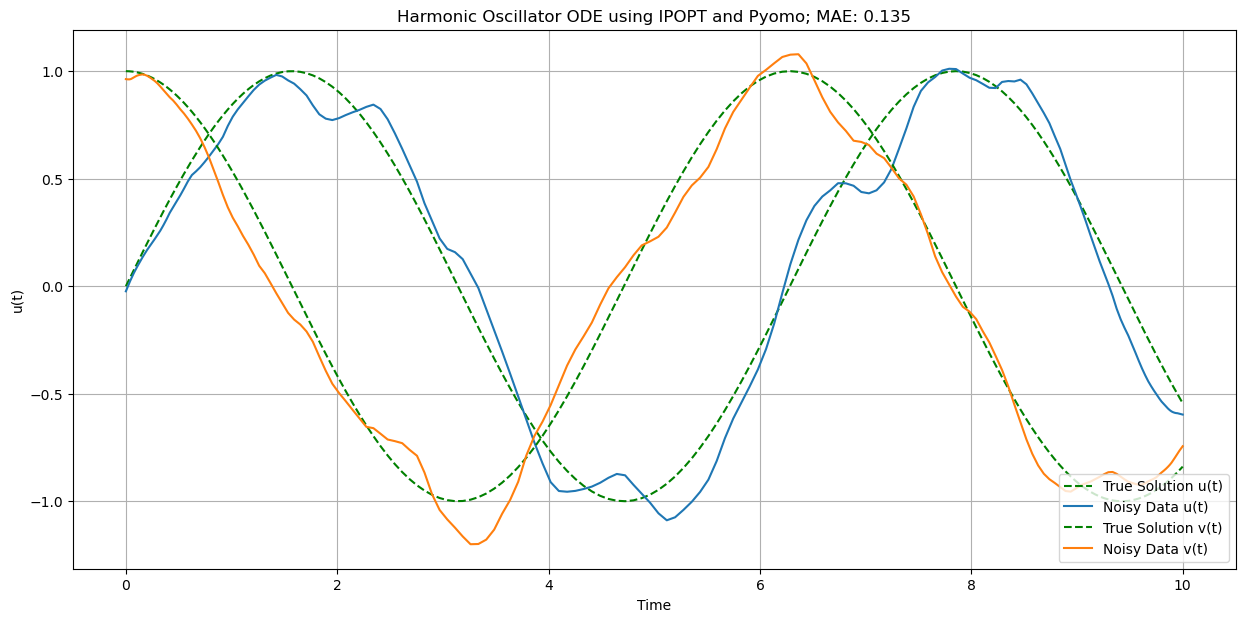

In [117]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t, y.T[0], 'g--', label='True Solution u(t)')
plt.plot(t, estimated_solution[0], label='Noisy Data u(t)')
plt.plot(t, y.T[1], 'g--', label='True Solution v(t)')
plt.plot(t, estimated_solution[1], label='Noisy Data v(t)')

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.title(f'Harmonic Oscillator ODE using IPOPT and Pyomo; MAE: {MAE:.3f}')
plt.grid(True)
plt.show()

In [109]:
model = optimization_model_testing(1000, 200, "sigmoid", "random", estimated_solution) # random

#---------------------------EXTRACTING RESULTS--------------------------#
u_solution = np.array([value(model.u[i]) for i in model.t_idx])
v_solution = np.array([value(model.v[i]) for i in model.t_idx])

#------------------------------INTERPOLATION----------------------------#
N = 200
interp_fn = interp1d(t, u_solution, kind='cubic', fill_value='extrapolate')
x_new = np.linspace(t[0], t[-1], N)
u_new = interp_fn(x_new)

interp_fn = interp1d(t, v_solution, kind='cubic', fill_value='extrapolate')
x_new = np.linspace(t[0], t[-1], N)
v_new = interp_fn(x_new)

_, y_temp, _, _ = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, "equally_spaced", initial_state)
combined = np.vstack((u_new, v_new)).T
MAE = np.mean(np.abs(y_temp - combined))
print(MAE)

model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number of Iterations
      Exceeded.
0.058725897564939865


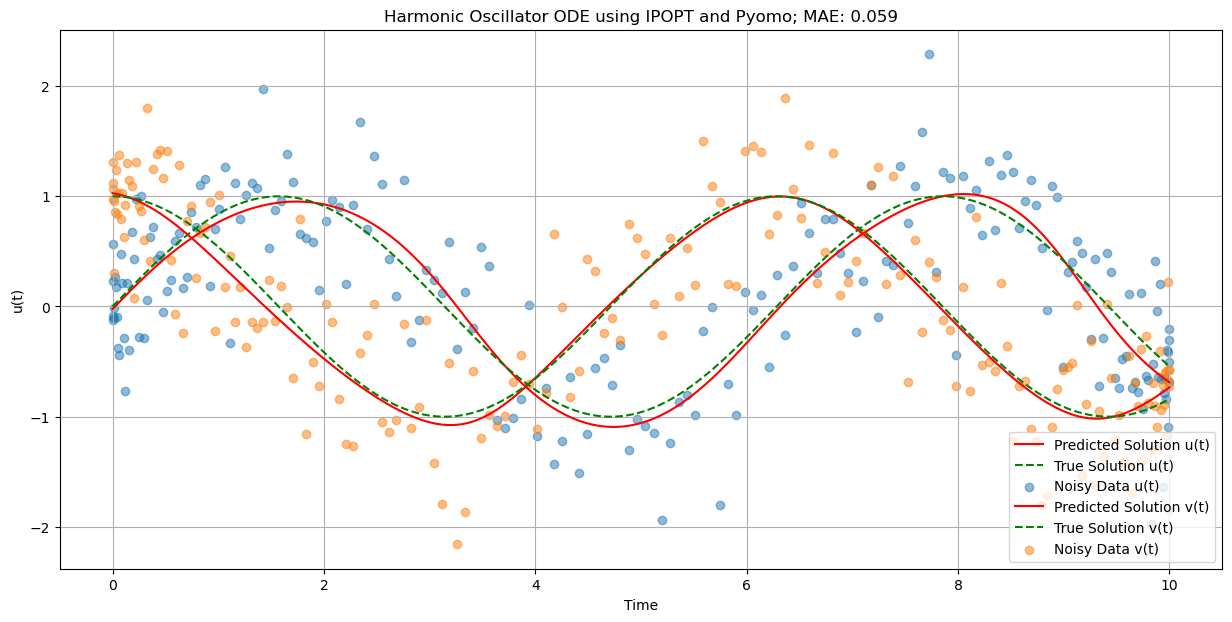

In [110]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(x_new, u_new, 'r', label='Predicted Solution u(t)')
plt.plot(t_temp, y_temp.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

plt.plot(x_new, v_new, 'r', label='Predicted Solution v(t)')
plt.plot(t_temp, y_temp.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.title(f'Harmonic Oscillator ODE using IPOPT and Pyomo; MAE: {MAE:.3f}')
plt.grid(True)
plt.show()

In [111]:
model = optimization_model_testing(1000, 200, "sigmoid", "random") # random

#---------------------------EXTRACTING RESULTS--------------------------#
u_solution = np.array([value(model.u[i]) for i in model.t_idx])
v_solution = np.array([value(model.v[i]) for i in model.t_idx])

#------------------------------INTERPOLATION----------------------------#
N = 200
interp_fn = interp1d(t, u_solution, kind='cubic', fill_value='extrapolate')
x_new = np.linspace(t[0], t[-1], N)
u_new = interp_fn(x_new)

interp_fn = interp1d(t, v_solution, kind='cubic', fill_value='extrapolate')
x_new = np.linspace(t[0], t[-1], N)
v_new = interp_fn(x_new)

_, y_temp, _, _ = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, "equally_spaced", initial_state)
combined = np.vstack((u_new, v_new)).T
MAE = np.mean(np.abs(y_temp - combined))
print(MAE)

model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number of Iterations
      Exceeded.
0.13541655089707386


## Van Der Pol Oscillator

In [109]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 150
noise_level = 0.2
ode_type = "van_der_pol"
params = {"mu": 0.5}
start_time=0
end_time=10
spacing_type="chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#---------------------------COLLOCATION MATRIX--------------------------#
weights = compute_weights(t)
D = lagrange_derivative(t, weights)
D = np.array(D)

#---------------------------MODEL CREATION--------------------------#
model = ConcreteModel()
model.t_idx = RangeSet(0, len(y_noisy)-1)
model.dim_idx = RangeSet(0, 1)  # ???

#---------------------------VARIABLE DEFINITIONS--------------------------#
model.u = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1)
model.v = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1)

input_size = 3  # t, u, v
hidden_size = 10  
output_size = 2  # du/dt and dv/dt

#--------------------WEIGHTS AND BIASES----------------------#
def initialize_weights(shape):
    return np.random.randn(*shape) * 0.1

def initialize_biases(size):
    return np.random.randn(size) * 0.1

model.W1 = pyo.Var(range(hidden_size), range(input_size), initialize=lambda m, i, j: initialize_weights((hidden_size, input_size))[i, j])
model.b1 = pyo.Var(range(hidden_size), initialize=lambda m, i: initialize_biases(hidden_size)[i])
model.W2 = pyo.Var(range(output_size), range(hidden_size), initialize=lambda m, i, j: initialize_weights((output_size, hidden_size))[i, j])
model.b2 = pyo.Var(range(output_size), initialize=lambda m, i: initialize_biases(output_size)[i])

#---------------------------INITIAL CONDITIONS---------------------------#
# model.initial_conditions = ConstraintList() 
# model.initial_conditions.add(model.u[0] == 1.0)

#---------------------------NEURAL NETWORK DEFINITIONS---------------------------#
def nn_output(t, u, v, m):
    # Hidden layer (tanh activation)
    hidden_layer = [sum(m.W1[i, j] * (t if j == 0 else u if j == 1 else v) for j in range(input_size)) + m.b1[i] for i in range(hidden_size)]
    hidden_layer_tanh = [pyo.tanh(z) for z in hidden_layer]
    
    # Output layer
    output = [sum(m.W2[k, i] * hidden_layer_tanh[i] for i in range(hidden_size)) + m.b2[k] for k in range(output_size)]
    return output

#---------------------------ODE CONSTRAINTS USING COLLOCATION MATRIX--------------------------#
penalty_terms = []
penalty_lambda = 5000
# ODE constraints using collocation matrix
model.ode = ConstraintList()
for i in range(1, N):
    du_dt = sum(D[i, j] * model.u[j] for j in range(N))
    dv_dt = sum(D[i, j] * model.v[j] for j in range(N))
    
    nn_u, nn_v = nn_output(t[i], model.u[i], model.v[i], model)
    
    collocation_constraint_u = nn_u - du_dt
    collocation_constraint_v = nn_v - dv_dt
    
    model.ode.add(collocation_constraint_u == 0)
    model.ode.add(collocation_constraint_v == 0)
    
    penalty_terms.append((collocation_constraint_u)**2 + (collocation_constraint_v)**2)

#---------------------------OBJECTIVE FUNCTION DEFINITION--------------------------#
def _objective(m):
    data_fit = sum((m.u[i] - y_noisy[i, 0])**2 + (m.v[i] - y_noisy[i, 1])**2 for i in m.t_idx)
    penalty = penalty_lambda * sum(penalty_terms)
    return penalty + data_fit

model.obj = Objective(rule=_objective, sense=pyo.minimize)
    
#---------------------------SOLVING THE MODEL--------------------------#
solver = pyo.SolverFactory('ipopt')

"""solver.options['tol'] = 1e-6
solver.options['bound_push'] = 1e-8
solver.options['constr_viol_tol'] = 1e-8"""

solver.options['max_iter'] = 500
solver.solve(model, tee=True)

Ipopt 3.14.16: max_iter=500


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    60196
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    65559

Total number of variables............................:      362
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      298

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 298, 'Number of variables': 362, 'Sense': 'unknown'}], 'Solver': [{'Status': 'warning', 'Message': 'Ipopt 3.14.16\\x3a Maximum Number of Iterations Exceeded.', 'Termination condition': 'maxIterations', 'Id': 400, 'Error rc': 0, 'Time': 27.90865683555603}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

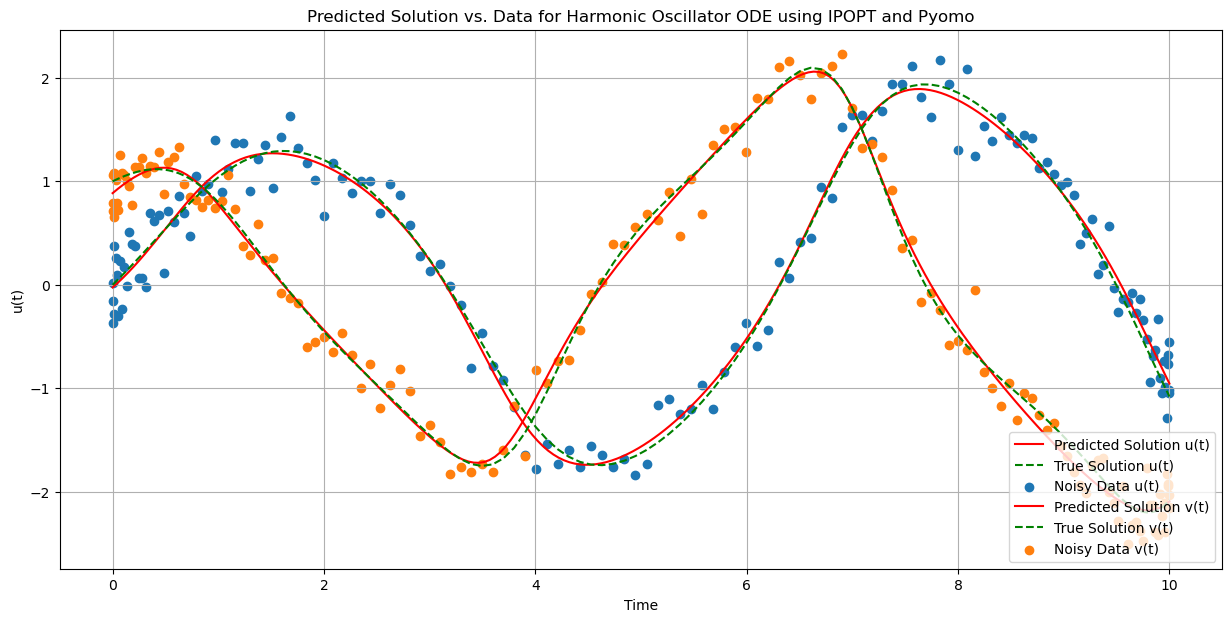

In [110]:
#---------------------------EXTRACTING RESULTS--------------------------#
u_solution = np.array([value(model.u[i]) for i in model.t_idx])
v_solution = np.array([value(model.v[i]) for i in model.t_idx])
# print(f"{value(model.C):.4f}")

#---------------------------INTERPOLATION--------------------------#
interp_fn = interp1d(t, u_solution, kind='cubic', fill_value='extrapolate')
x_new = np.linspace(t[0], t[-1], 200)
u_new = interp_fn(x_new)

interp_fn = interp1d(t, v_solution, kind='cubic', fill_value='extrapolate')
x_new = np.linspace(t[0], t[-1], 200)
v_new = interp_fn(x_new)

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(x_new, u_new, 'r', label='Predicted Solution u(t)')
plt.plot(t, y.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)')

plt.plot(x_new, v_new, 'r', label='Predicted Solution v(t)')
plt.plot(t, y.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)')
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.title('Predicted Solution vs. Data for Harmonic Oscillator ODE using IPOPT and Pyomo')
plt.grid(True)
plt.show()